# Préparez des données pour un organisme de santé publique

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

## Étape 1 : Nettoyez et filtrez des features et produits 

In [136]:
df = pd.read_csv("fr.openfoodfacts.org.products.csv", sep="\t", low_memory=False)

df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Commençons par analyser un petit peu les données.

In [137]:
df.shape

(320772, 162)

In [138]:
df.columns

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'generic_name', 'quantity',
       ...
       'ph_100g', 'fruits-vegetables-nuts_100g',
       'collagen-meat-protein-ratio_100g', 'cocoa_100g', 'chlorophyl_100g',
       'carbon-footprint_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g',
       'water-hardness_100g'],
      dtype='object', length=162)

Nous allons séléctioner une variable ayant entre 50% et 80% de valeurs manquantes. Ce sera notre variable à analyser.

In [139]:
missing_values = df.isnull().mean()

missing_values.loc[missing_values > 0.5].loc[missing_values < 0.8].sort_values()

additives_tags      0.517788
additives_fr        0.517788
cholesterol_100g    0.550802
trans-fat_100g      0.553271
calcium_100g        0.560280
vitamin-c_100g      0.560850
iron_100g           0.562113
vitamin-a_100g      0.571178
quantity            0.673229
pnns_groups_2       0.705426
pnns_groups_1       0.714710
categories_fr       0.736850
categories          0.736854
categories_tags     0.736919
main_category_fr    0.736991
main_category       0.736991
packaging_tags      0.753841
packaging           0.753844
image_url           0.763583
image_small_url     0.763583
dtype: float64

La variable "main_category" paraît parfaite. C'est une variable catégorielle et elle est ni trop vide ni trop remplis.

In [140]:
target = df["main_category"]

Maintenant, visualisons les données en fonctions du pourcentage de valuers manquantes.

Text(0.5, 1.0, 'Pourcentage de valeurs manquantes pour chaque variable')

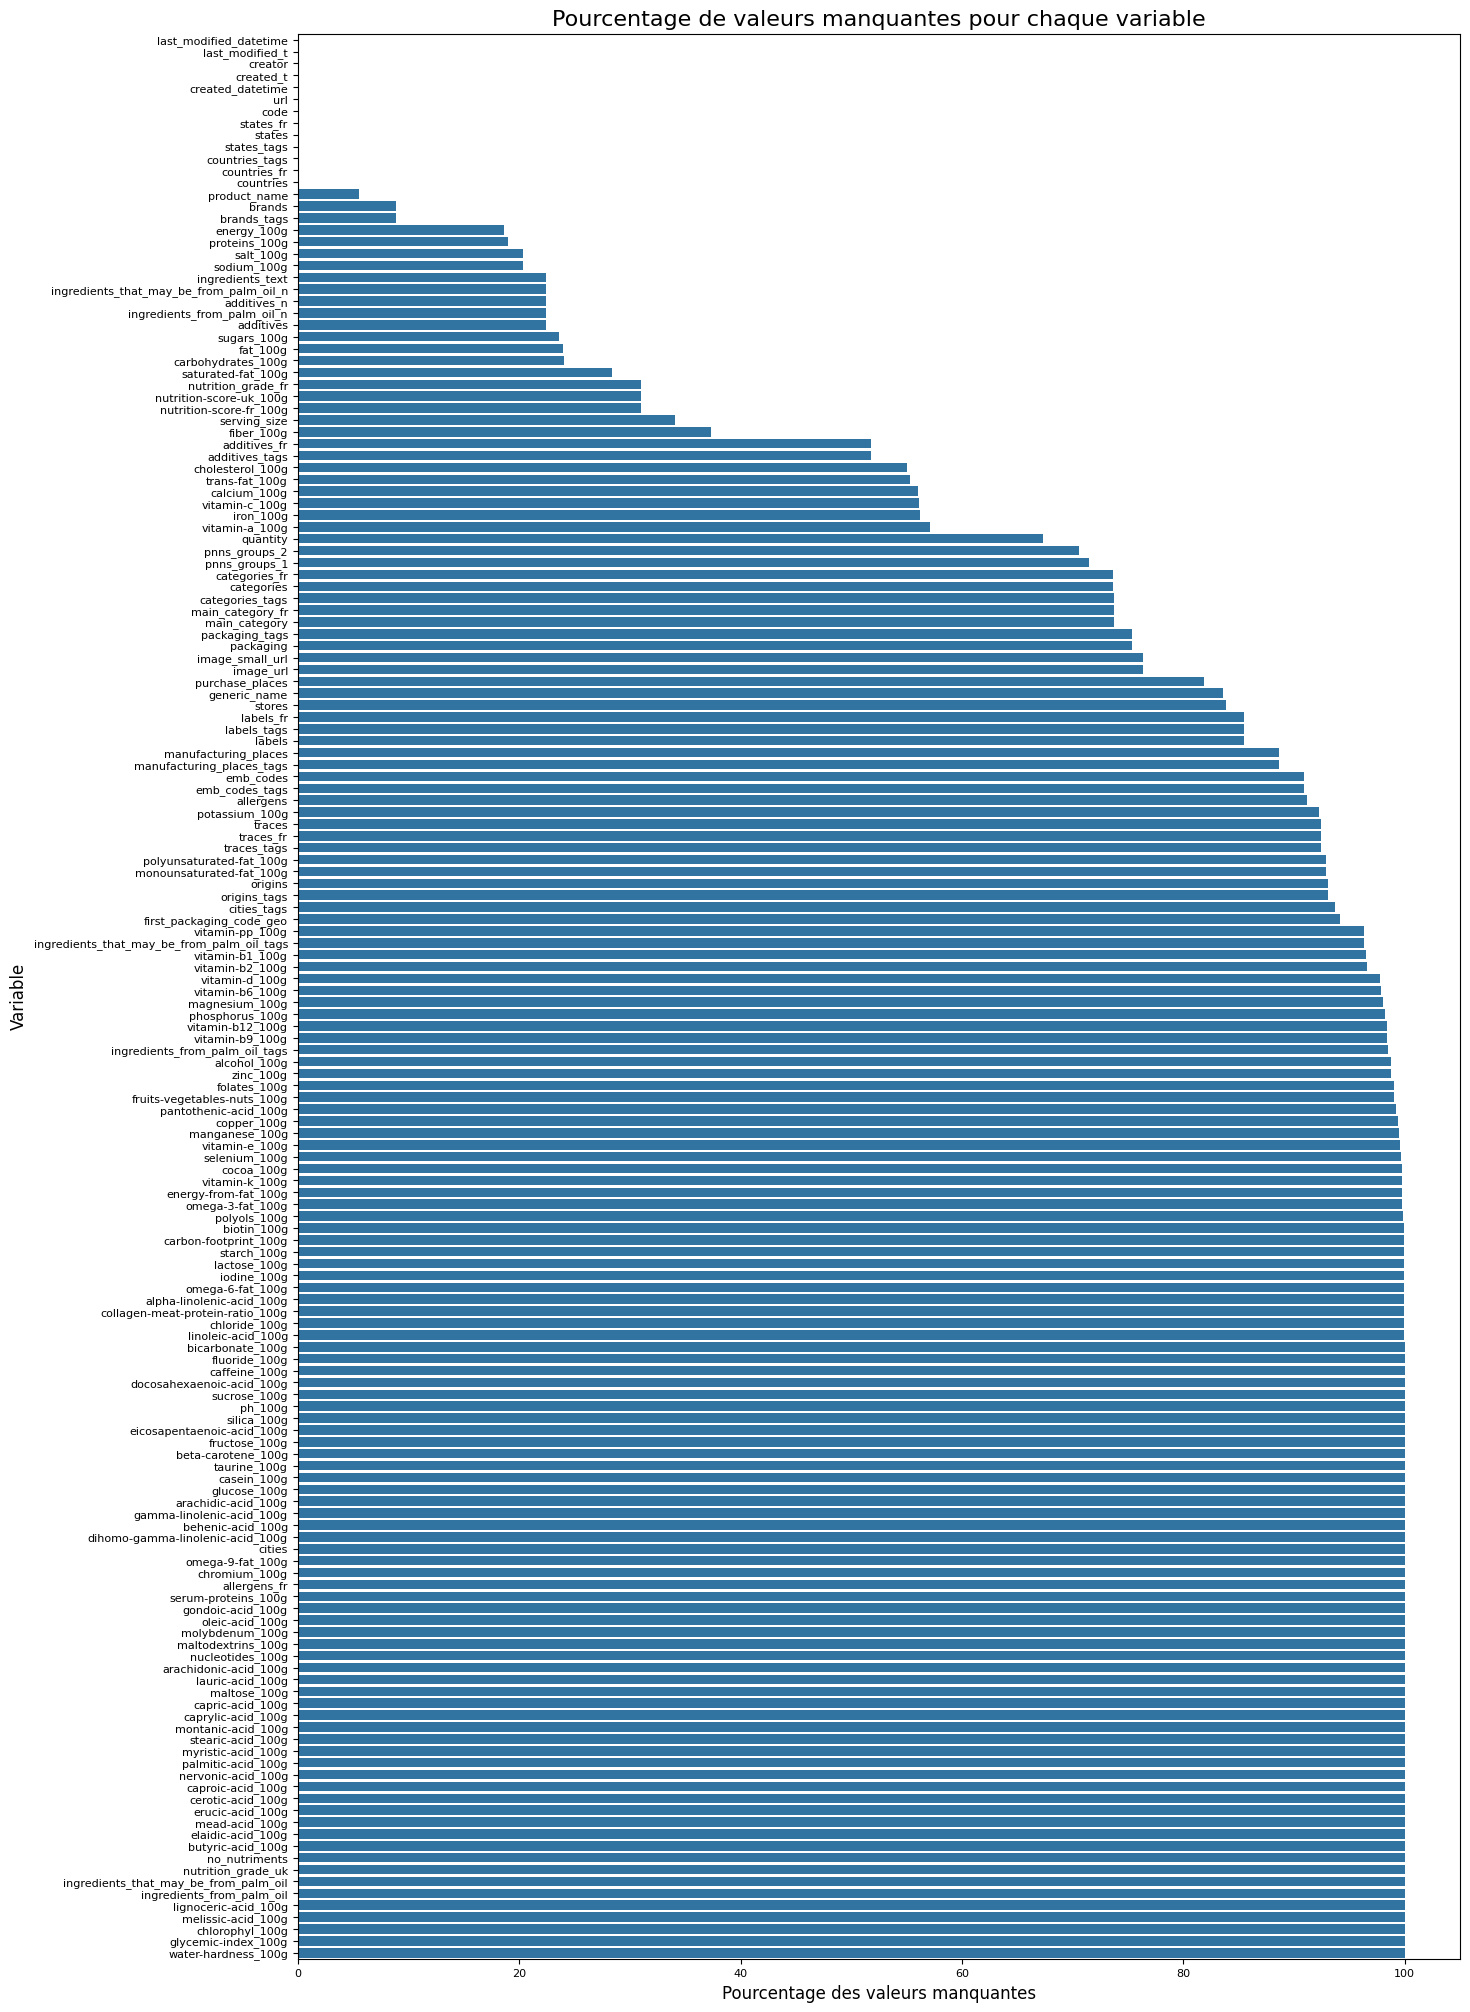

In [141]:
proportion_of_emptiness = df.isnull().mean() * 100
proportion_of_emptiness = pd.DataFrame(proportion_of_emptiness).reset_index().sort_values(0)

fig = plt.figure(figsize=(15, 25))

plt.rcParams.update({"font.size": 8})
sns.barplot(data=proportion_of_emptiness, x=0, y="index")
plt.xlabel("Pourcentage des valeurs manquantes", fontsize=12)
plt.ylabel("Variable", fontsize=12)
plt.title("Pourcentage de valeurs manquantes pour chaque variable", fontsize=16)

Supprimons les variables comportants moins de 50% de taux de remplissage.

In [142]:
df = df.loc[:, missing_values < 0.5]

Utilisons l'URL des produits pour supprimer les doublons.

In [143]:
duplicated_rows = df["url"].duplicated()
duplicated_rows.sum()

np.int64(22)

In [144]:
df = df.loc[duplicated_rows == False]
df.duplicated().sum()

np.int64(0)

Nous allons maintenant faire la sélection des variables qui seront destinées à prédire la variable cible. Pour cela, nous choisissons des variables étant remplies au minimum à 50%. Il faut, bien sûr, aussi qu'elles aient un rapport avec notre variable cible afin qu'elles puissent la prédire.

In [145]:
df = df[[
    "nutrition_grade_fr",
    "energy_100g",
    "fat_100g",
    "sugars_100g",
    "fiber_100g",
    "proteins_100g",
    "salt_100g"
]]

In [146]:
def features_selection(dataframe):
    dataframe.columns
    target = dataframe["main_category"]
    df.isnull().mean()
    dataframe = dataframe.loc[df["code"].duplicated() == False]
    dataframe = dataframe[[
        "brands",
        "ingredients_text",
        "nutrition_grade_fr",
        "energy_100g",
        "fat_100g",
        "sugars_100g",
        "fiber_100g",
        "proteins_100g",
        "salt_100g"
    ]]
    return (dataframe, target)

## Étape 2 : Identifiez et traitez les valeurs aberrantes

Occupons-nous maintenant de traiter les valeurs aberrantes. Pour cela, nous allons en premier lieu utiliser des boîtes à moustaches afin de visualiser la distribution des valeurs nutritives.

(320750, 7)


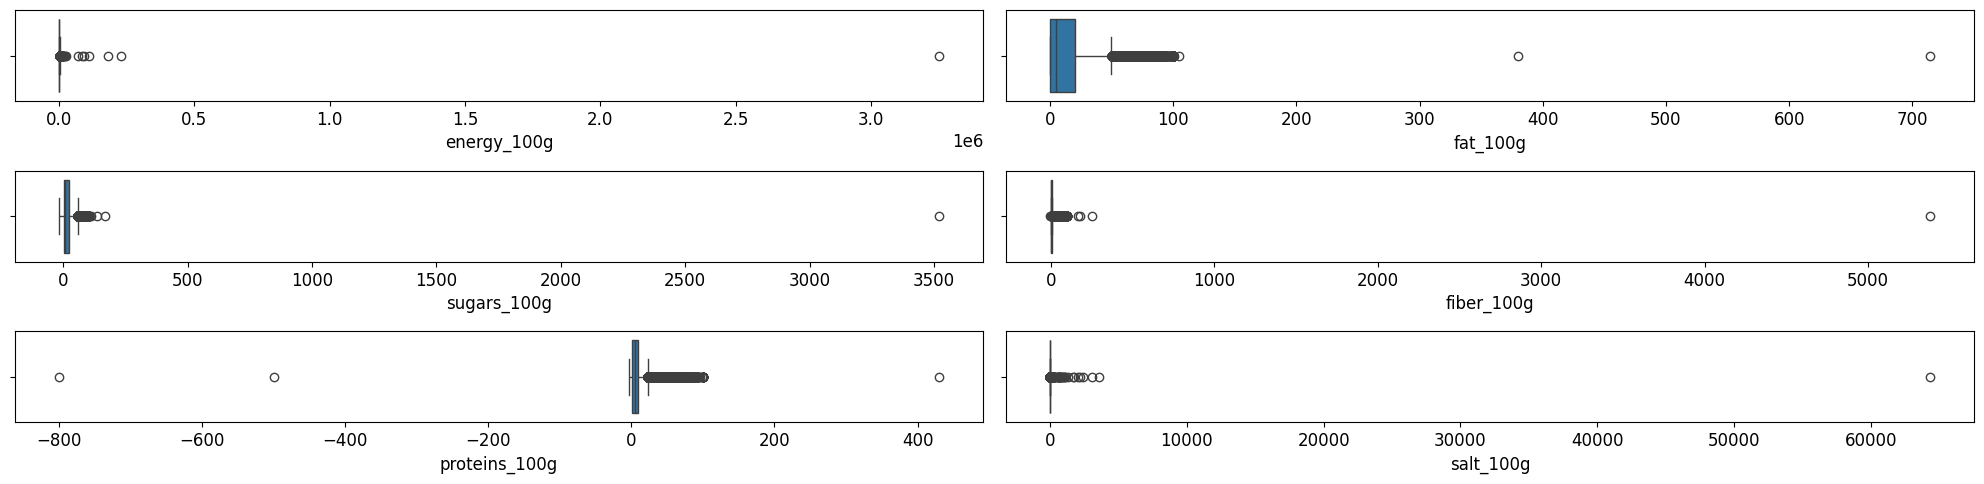

In [147]:
nutritive_values = ["energy_100g", "fat_100g", "sugars_100g", "fiber_100g", "proteins_100g", "salt_100g"]

plt.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(3, 2, figsize=(20,5))

ax = ax.flatten()
for i, value in enumerate(nutritive_values[0:len(nutritive_values)]):
    sns.boxplot(data=df, x=value, ax=ax[i])

plt.tight_layout()
print(df.shape)

On repère deux problèmes. Premièrement, certaines valeurs sont négatives, ce qui, vous en conviendrez, est impossible. Deuxièmement, des valeurs dépassent la valeur maximum possible pour ce type de données. Par exemple, le produit le plus gras contient plus de 700g de gras pour 100g de produit. C'est bien évidemment impossible. Nous allons donc supprimer les valeurs en trop, et nous allons même rechercher les aliments contenant le plus de protéines et de fibres possible, ainsi que l'aliment apportant le plus de kilos joules au corps, afin d'estimer des valeurs maximum plus précises pour ces données.

In [148]:
df = df.loc[((df["energy_100g"] >= 0) & (df["energy_100g"] < 3700)) | (df["energy_100g"].isna())]
df = df.loc[((df["fat_100g"] >= 0) & (df["fat_100g"] < 100)) | (df["fat_100g"].isna())]
df = df.loc[((df["sugars_100g"] >= 0) & (df["sugars_100g"] < 100)) | (df["sugars_100g"].isna())]
df = df.loc[((df["fiber_100g"] >= 0) & (df["fiber_100g"] < 16)) | (df["fiber_100g"].isna())]
df = df.loc[((df["proteins_100g"] >= 0) & (df["proteins_100g"] < 58)) | (df["proteins_100g"].isna())]
df = df.loc[((df["salt_100g"] >= 0) & (df["salt_100g"] < 100)) | (df["salt_100g"].isna())]
df.isna().mean()

nutrition_grade_fr    0.310935
energy_100g           0.189722
fat_100g              0.242752
sugars_100g           0.237809
fiber_100g            0.375806
proteins_100g         0.193303
salt_100g             0.207014
dtype: float64

Maintenant que nous nous sommes débarrassés des valeurs explicitement aberrantes, nous allons utiliser des méthodes statistiques pour en détecter davantage.

In [149]:
# iqr_scores = []

# for value in nutritive_values:
#     iqr = np.quantile(df[value], q=[0.25, 0.75])
#     iqr_scores.append((iqr[1] + 1.5*(iqr[1] - iqr[0])))

# iqr_scores_df = pd.DataFrame(iqr_scores)
# iqr_scores_df.index = nutritive_values
# iqr_scores_df.rename(columns={0:"IQR scores"}, inplace=True)
# iqr_scores_df

Maintenant, nous allons supprimer les produits dont les valeurs dépassent le score interquartile.

In [150]:
# for value in iqr_scores_df.index:
#     df = df.loc[df[value] <= iqr_scores_df.loc[value, "IQR scores"]]


# fig, ax = plt.subplots(3, 2, figsize=(20,5))
# ax = ax.flatten()

# for i, value in enumerate(nutritive_values[0:len(nutritive_values)]):
#     sns.boxplot(data=df, x=value, ax=ax[i])
# plt.tight_layout()
# print(df.shape)

Nous allons aussi analyser le nutriscore des produits. En premier lieu, vérifions que les seules valeurs présentes sont a, b, c, d, e. Ensuite, mettons en place un histogramme pour en apprendre davantage sur la distribution de ces valeurs.

In [151]:
df["nutrition_grade_fr"].unique()

array([nan, 'd', 'b', 'c', 'a', 'e'], dtype=object)

<Axes: xlabel='nutrition_grade_fr', ylabel='Count'>

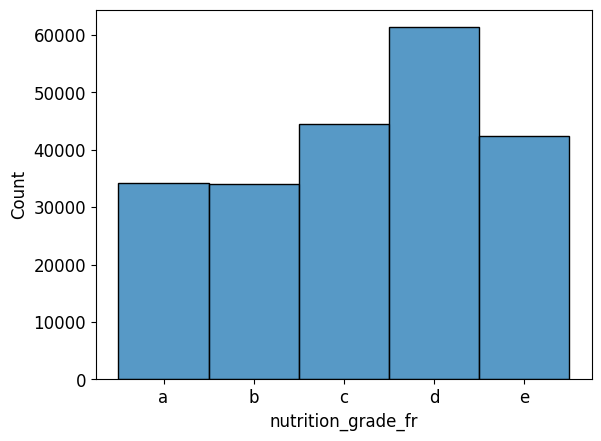

In [152]:
df['nutrition_grade_fr'] = pd.Categorical(df['nutrition_grade_fr'], ["a","b","c","d","e"])
sns.histplot(data=df["nutrition_grade_fr"])

## Étape 3 : Identifiez et traitez les valeurs manquantes

Nous allons maintenant tenter de remplir les valeurs manquantes de notre DataFrame. Pour ceci, nous allons d'abord analyser la corrélation entre nos variables.

<Axes: >

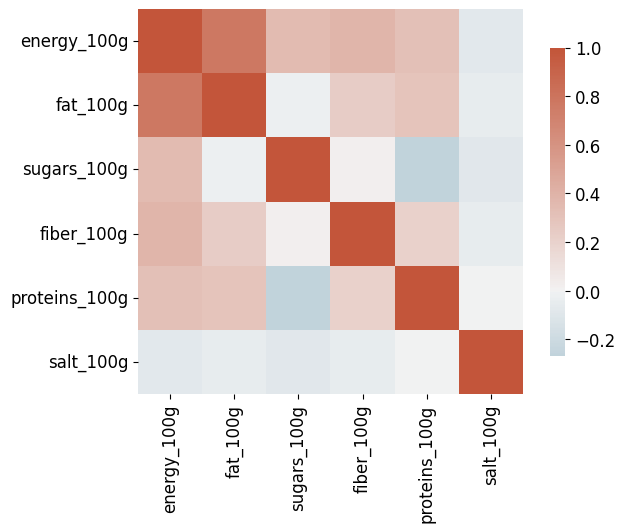

In [153]:
corr_matrix = df[nutritive_values].corr()

f, ax = plt.subplots(figsize=(7, 5))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, cmap=cmap, center=0, square=True, cbar_kws={"shrink": .8})

Nos donné

In [154]:
imputer = IterativeImputer(random_state=1)
imputed = imputer.fit_transform(df[nutritive_values])
df[nutritive_values] = pd.DataFrame(imputed, columns=df[nutritive_values].columns)
df.isna().mean()

/home/titouan/.local/share/virtualenvs/p3-_3AbF7j9/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


nutrition_grade_fr    0.310935
energy_100g           0.020756
fat_100g              0.020756
sugars_100g           0.020756
fiber_100g            0.020756
proteins_100g         0.020756
salt_100g             0.020756
dtype: float64

In [155]:
df.dropna(subset=nutritive_values, inplace=True)
df.isna().mean()

nutrition_grade_fr    0.305006
energy_100g           0.000000
fat_100g              0.000000
sugars_100g           0.000000
fiber_100g            0.000000
proteins_100g         0.000000
salt_100g             0.000000
dtype: float64

(307660, 7)


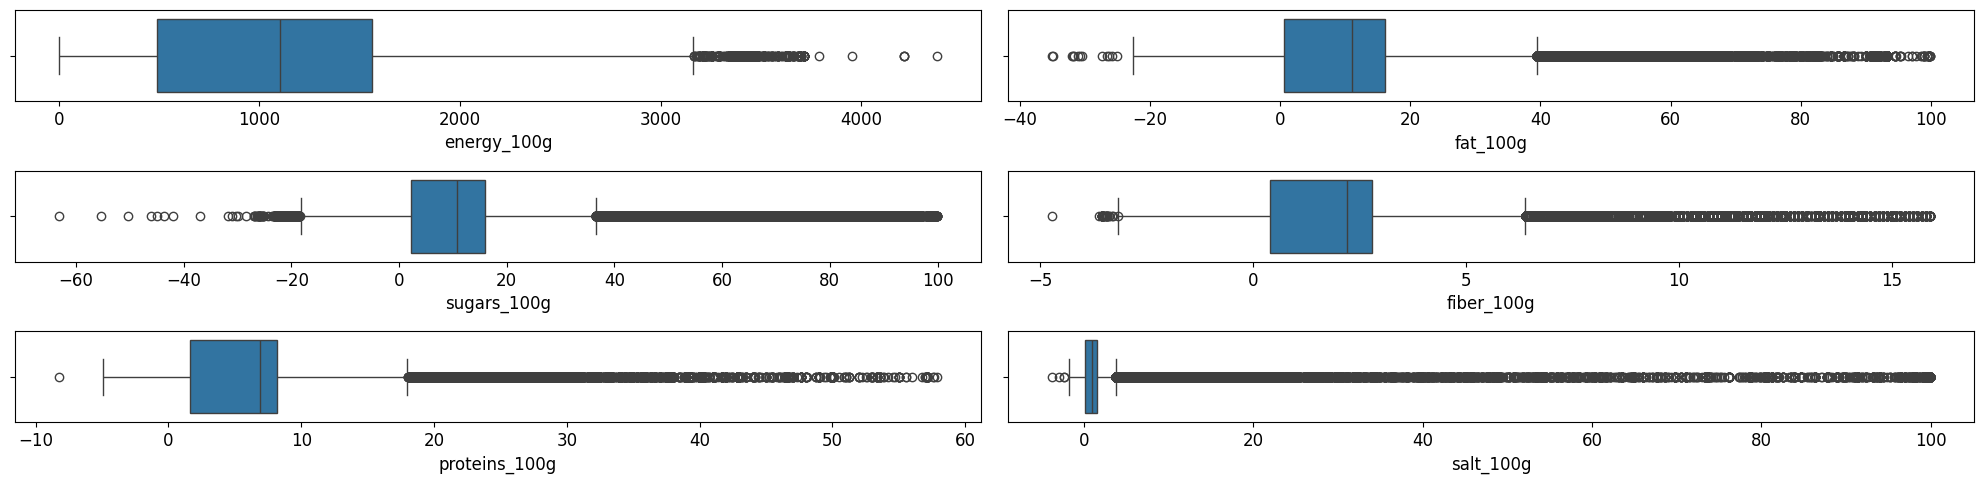

In [156]:
fig, ax = plt.subplots(3, 2, figsize=(20,5))

ax = ax.flatten()

for i, value in enumerate(nutritive_values[0:len(nutritive_values)]):
    sns.boxplot(data=df, x=value, ax=ax[i])
plt.tight_layout()
print(df.shape)

In [157]:
# plt.plot(figsize=(20,20))
# sns.regplot(data = df, x = "fat_100g", y = "energy_100g", line_kws={"color":"r"}, scatter_kws={"s":1}, x_bins=np.arange(0, 55, 1), order=2)

In [158]:
df_train = df.dropna()

encoder = LabelEncoder()
df_train.loc[:, "nutrition_grade_fr"] = encoder.fit_transform(df_train["nutrition_grade_fr"])

scaler = MinMaxScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df_train.columns)

/tmp/ipykernel_10981/1977821320.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[3 1 3 ... 4 2 2]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  df_train.loc[:, "nutrition_grade_fr"] = encoder.fit_transform(df_train["nutrition_grade_fr"])


<Axes: >

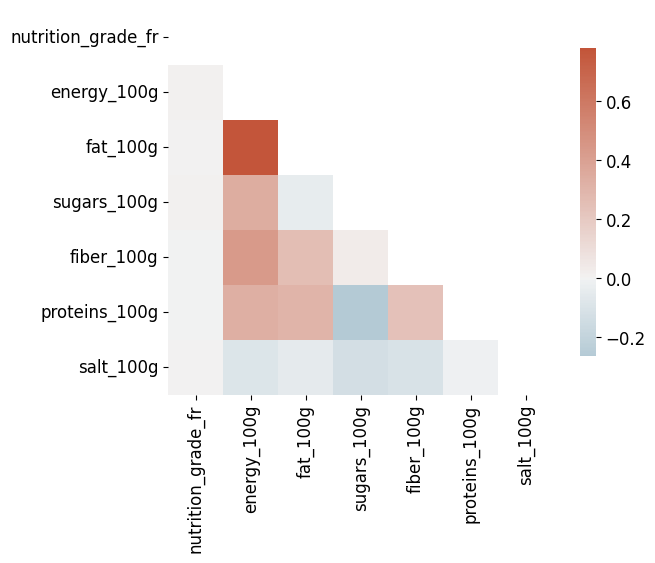

In [159]:
corr_matrix = df_train.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

f, ax = plt.subplots(figsize=(7, 5))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, square=True, cbar_kws={"shrink": .8})

In [160]:
# plt.plot(figsize=(20,20))
# sns.regplot(data = df_train, x = "nutrition_grade_fr", y = "energy_100g", line_kws={"color":"r"}, scatter_kws={"s":1}, order=4)

In [161]:
imputer = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(df_train[["energy_100g", "fat_100g", "sugars_100g", "salt_100g", "proteins_100g", "fiber_100g"]], df_train["nutrition_grade_fr"], test_size=0.8, random_state=1)
imputer.fit(X = X_train, y = y_train)
test = imputer.predict(X_test)
imputer.score(X_test, y_test)

-0.00013088069457389828

In [162]:
imputer = IterativeImputer(random_state=1)
imputed = imputer.fit_transform(df.replace(['a', 'b', 'c', 'd', 'e'], [0, 1, 2, 3, 4,]))
df_imputed = pd.DataFrame(imputed, columns=df.columns)
df_imputed

/tmp/ipykernel_10981/1583103744.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  imputed = imputer.fit_transform(df.replace(['a', 'b', 'c', 'd', 'e'], [0, 1, 2, 3, 4,]))
/tmp/ipykernel_10981/1583103744.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  imputed = imputer.fit_transform(df.replace(['a', 'b', 'c', 'd', 'e'], [0, 1, 2, 3, 4,]))


,nutrition_grade_fr,energy_100g,fat_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g
0,2.200774,1104.120058,12.336414,15.277933,2.263460,6.932391,1.587331
1,3.000000,2243.000000,28.570000,14.290000,3.600000,3.570000,0.000000
2,1.000000,1941.000000,17.860000,17.860000,7.100000,17.860000,0.635000
3,3.000000,2540.000000,57.140000,3.570000,7.100000,17.860000,1.224280
4,2.210210,1552.000000,1.430000,33.441335,5.700000,8.570000,0.669543
...,...,...,...,...,...,...,...
307655,2.000000,1104.120058,12.336414,15.277933,2.263460,6.932391,1.587331
307656,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
307657,4.000000,1104.120058,12.336414,15.277933,2.263460,6.932391,1.587331
307658,2.000000,1104.120058,12.336414,15.277933,2.263460,6.932391,1.587331
